<a href="https://colab.research.google.com/github/AanchalA/WeekendProjects/blob/main/MRI_Brain_Tumor_Detecor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Tumor Segmentation, generating some heat-maps
- Interpretiibility
- Combining multiple datasets - https://www.kaggle.com/search?q=brain+tumor+datasets+in%3Adatasets
- Try other, more complex models like VGG (Transfer learning), masked-cnn, etc.
- Model Deployment

In [ ]:
import torch

import cv2
import glob
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Dataset

In [ ]:
# import pandas
from pathlib import Path
try:
    import opendatasets as od
except:
    ! pip install -q opendatasets
    import opendatasets as od
from torch.utils.data import Dataset, DataLoader

## Downloading the Dataset

In [ ]:
dataset_URL = "https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection"
od.download(dataset_URL)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aanchala
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


100%|██████████| 15.1M/15.1M [00:00<00:00, 47.0MB/s]


## Loading the Dataset

In [ ]:
data_path = "/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
yes_path = data_path + "/yes/*.[jJ][pP][gG]"        ## To get image.JPG and image.jpg
no_path = data_path + "/no/*.[jJ][pP][gG]"

TODO: Setting the image size based on the min of height and width values.

In [ ]:
tumor = list()
for f in glob.iglob(yes_path):
    img = cv2.imread(f)                         ## Images are not of standard shape, all of them have 3 channels
    img = cv2.resize(img, (128, 128))           ## Image channels are in B-G-R format, we want to put them in R-G-B format
    b, g, r = cv2.split(img)                    ## Splitting the image into indiviindividual channels
    img = cv2.merge([r, g, b])
    tumor.append(img)

len(tumor)

154

In [ ]:
# for img in tumor:
#     print(img.shape)            ## Images are not of standard shape, all of them have 3 channels
tumor[0].shape

(128, 128, 3)

In [ ]:
healthy = list()
for f in glob.iglob(no_path):
    img = cv2.imread(f)                         ## Images are not of standard shape, all of them have 3 channels
    img = cv2.resize(img, (128, 128))           ## Image channels are in B-G-R format, we want to put them in R-G-B format
    b, g, r = cv2.split(img)                    ## Splitting the image into indiviindividual channels
    img = cv2.merge([r, g, b])
    healthy.append(img)

len(healthy)

91

In [ ]:
# for img in healthy:
#     print(img.shape)            ## Images are not of standard shape, all of them have 3 channels
healthy[0].shape

(128, 128, 3)

## Converting Data to Numpy Arrays

In [ ]:
tumor = np.array(tumor)
print(f"Tumor Shape: {tumor.shape}")                    ## [Batch_Size, Height, Width, Num_Channels]

healthy = np.array(healthy)
print(f"Healthy Shape: {healthy.shape}")

all = np.concatenate((tumor, healthy))
print(f"All Shape: {all.shape}")

Tumor Shape: (154, 128, 128, 3)
Healthy Shape: (91, 128, 128, 3)
All Shape: (245, 128, 128, 3)


## Data Visualization

(-0.5, 127.5, 127.5, -0.5)

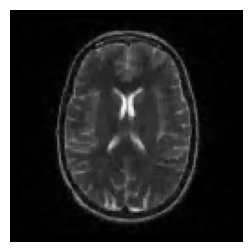

In [ ]:
plt.figure(figsize=(3, 5))
plt.imshow(healthy[0])
plt.axis(False)

(-0.5, 127.5, 127.5, -0.5)

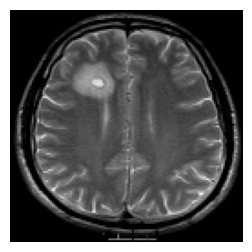

In [ ]:
plt.figure(figsize=(3, 5))
plt.imshow(tumor[0])
plt.axis(False)

In [ ]:
def plot_random(tumor: np.array,
                healthy: np.array,
                num: int=5):

    tumor_selected = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    healthy_selected = healthy[np.random.choice(healthy.shape[0], num, replace=False)]

    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title("Healthy")
        plt.imshow(healthy_selected[i])
        plt.axis(False)

    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title("Tumor")
        plt.imshow(tumor_selected[i])
        plt.axis(False)

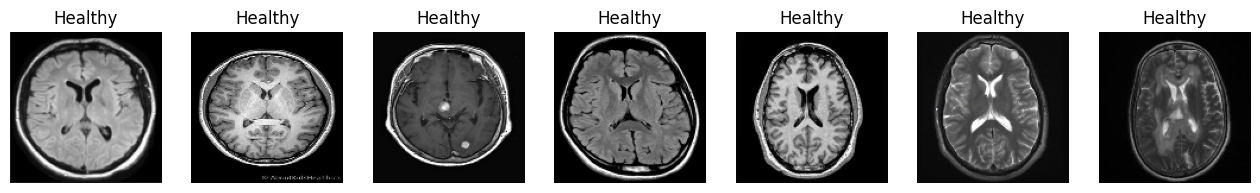

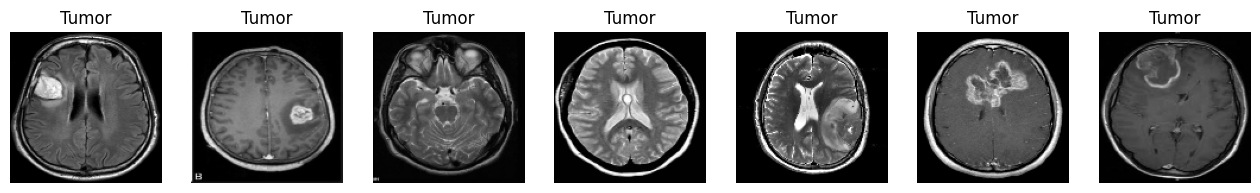

In [ ]:
plot_random(tumor, healthy, num=7)

## Creating PyTorch Dataset Class

In [ ]:
from torchvision import transforms

In [ ]:
# class BrainMRIDataset(Dataset):
#     def __init__(self, images, labels):
#         # super()__init__()               ## Here we do not use super().__init__() because the Dataset class does not have a constructor.
#         self.images = images
#         self.labels = labels

#     def __len__(self):
#         # return len(self.images)           ## len() Works better with list data, numpy arrays and torch tensors have dimensionality
#         return self.images.shape[0]

#     def __getitem__(self, index):
#         sample = ("image": self.images[index], "label": self.labels[index])
#         return sample

Adding the load dataset part in the constructor itself

In [ ]:
class BrainMRIDataset(Dataset):
    def __init__(self):

        data_path = "/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
        yes_path = data_path + "/yes/*.[jJ][pP][gG]"        ## To get image.JPG and image.jpg
        no_path = data_path + "/no/*.[jJ][pP][gG]"

        tumor = list()
        healthy = list()
        # transformation = transforms.Compose([transforms.ToTensor()])

        for f in glob.iglob(yes_path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))           ## Images are not of standard shape, all of them have 3 channels
            # b, g, r = cv2.split(img)                  ## Splitting the image into indiviindividual channels
            # img = cv2.merge([r, g, b])                ## Image channels are in B-G-R format, we want to put them in R-G-B format
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)

        for f in glob.iglob(no_path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))           ## Images are not of standard shape, all of them have 3 channels
            # b, g, r = cv2.split(img)                  ## Splitting the image into indiviindividual channels
            # img = cv2.merge([r, g, b])                ## Image channels are in B-G-R format, we want to put them in R-G-B format
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)

        ## Images
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)
        self.images = np.concatenate((tumor, healthy), axis=0)    ## With axis=0 --> (100, 3, 128, 128) & (200, 3, 128, 128) beacomes (300, 3, 128, 128)
        # self.images = np.array([transformation(image) for image in self.images])

        ## Labels
        tumor_labels = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_labels = np.zeros(healthy.shape[0], dtype=np.float32)
        self.labels = np.concatenate((tumor_labels, healthy_labels))

    def __len__(self):
        # return len(self.images)           ## len() Works better with list data, numpy arrays and torch tensors have dimensionality
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {"image": self.images[index], "label": self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0

In [ ]:
dataset = BrainMRIDataset()

print("Before Data Normalization: ")
print(dataset[0]["image"].shape, " | ", dataset[0]["image"].min(), " | ", dataset[0]["image"].max(), " | ", dataset[0]["label"])

dataset.normalize()

print("After Data Normalization: ")
print(dataset[0]["image"].shape, " | ", dataset[0]["image"].min(), " | ", dataset[0]["image"].max(), " | ", dataset[0]["label"])

Before Data Normalization: 
(3, 128, 128)  |  0.0  |  255.0  |  1.0
After Data Normalization: 
(3, 128, 128)  |  0.0  |  1.0  |  1.0


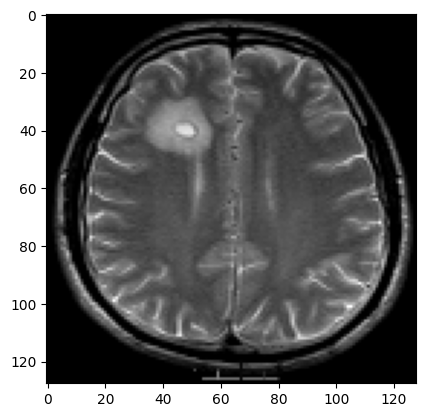

In [ ]:
plt.imshow(dataset[0]["image"].reshape(128, 128, 3))

## Creating a DataLoader

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
next(iter(dataloader))["image"][0].shape

torch.Size([3, 128, 128])

# Building the Model

In [ ]:
from torch import nn
# import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class BrainMRIModelCNN(nn.Module):
    def __init__(self):
        super(BrainMRIModelCNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )
        self.fc_model = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)         ## Flatten Layer | x.size(0) will take the first dim of x, that is the batch size, and -1 will take the rest of the dims, (batch_size, single_tensor_of all elements)
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
model = BrainMRIModelCNN().to(device)
model

BrainMRIModelCNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [ ]:
model.cnn_model[0].weight[0][0].dtype

torch.float32

# Evaluating The Un-Trained Model

In [ ]:
y_true = list()
y_preds = list()

model.eval()
with torch.no_grad():
    for data in dataloader:
        batch_images = data["image"].to(device)
        batch_y_true = data["label"].cpu().detach().numpy()

        batch_y_prob_preds = model(batch_images).squeeze()
        batch_y_prob_preds = batch_y_prob_preds.cpu().detach().numpy()
        batch_y_preds = np.round(batch_y_prob_preds)

        y_true.append(batch_y_true)
        y_preds.append(batch_y_preds)

In [ ]:
len(y_true), y_true[0].shape, len(y_preds), y_preds[0].shape

(8, (32,), 8, (32,))

In [ ]:
y_true = np.concatenate(y_true, axis=0)#.squeeze()
y_preds = np.concatenate(y_preds, axis=0)#.squeeze()

y_true.shape, y_preds.shape

((245,), (245,))

In [ ]:
y_true[:10], y_preds[:10]

(array([1., 0., 0., 0., 0., 1., 0., 1., 0., 1.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32))

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_preds, target_names=["Healthy", "Tumor"], zero_division=0.0))

              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        91
       Tumor       0.63      1.00      0.77       154

    accuracy                           0.63       245
   macro avg       0.31      0.50      0.39       245
weighted avg       0.40      0.63      0.49       245



Text(-4.277777777777779, 0.5, 'True Labels')

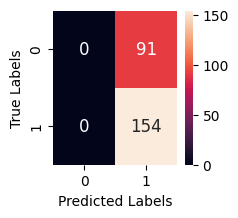

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_preds)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt="g", annot_kws={"size": 12})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
# plt.xticks(["Healthy", "Tumor"])
# plt.yticks(["Tumor", "Healthy"])

# Training the Model

In [ ]:
from tqdm.auto import tqdm

In [ ]:
EPOCHS = 401
loss_fn = nn.BCELoss()          # nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [ ]:
model.train()
for epoch in tqdm(range(EPOCHS)):
    train_losses = list()
    for data in dataloader:
        batch_images = data["image"].to(device)
        batch_labels = data["label"].to(device)
        batch_y_prob_preds = model(batch_images).squeeze()
        batch_loss = torch.sum(loss_fn(batch_y_prob_preds, batch_labels))
        train_losses.append(batch_loss.cpu().detach().numpy())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"EPOCH: {epoch} | LOSS: {np.mean(train_losses): .5f}")

  0%|          | 0/401 [00:00<?, ?it/s]

EPOCH: 0 | LOSS:  0.67891
EPOCH: 50 | LOSS:  0.48177
EPOCH: 100 | LOSS:  0.39490
EPOCH: 150 | LOSS:  0.26381
EPOCH: 200 | LOSS:  0.16307
EPOCH: 250 | LOSS:  0.09067
EPOCH: 300 | LOSS:  0.03318
EPOCH: 350 | LOSS:  0.01331
EPOCH: 400 | LOSS:  0.00669


# Evaluating the Trained Model

In [ ]:
y_true = list()
y_preds = list()

model.eval()
with torch.no_grad():
    for data in dataloader:
        batch_images = data["image"].to(device)
        batch_y_true = data["label"].cpu().detach().numpy()

        batch_y_prob_preds = model(batch_images).squeeze()
        batch_y_prob_preds = batch_y_prob_preds.cpu().detach().numpy()
        batch_y_preds = np.round(batch_y_prob_preds)

        y_true.append(batch_y_true)
        y_preds.append(batch_y_preds)

y_true = np.concatenate(y_true, axis=0)#.squeeze()
y_preds = np.concatenate(y_preds, axis=0)#.squeeze()

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_preds, target_names=["Healthy", "Tumor"], zero_division=0.0))

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        91
       Tumor       1.00      1.00      1.00       154

    accuracy                           1.00       245
   macro avg       1.00      1.00      1.00       245
weighted avg       1.00      1.00      1.00       245



Text(-4.277777777777779, 0.5, 'True Labels')

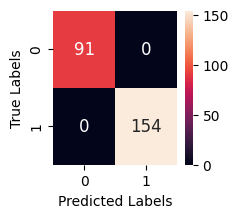

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_preds)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt="g", annot_kws={"size": 12})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
# plt.xticks(["Healthy", "Tumor"])
# plt.yticks(["Tumor", "Healthy"])

# Visualizing the Feature Maps of the CNN

Looking at the models children

In [ ]:
model_children = list(model.children())
model_children, len(model_children)         ## The model has 2 children - 2 sequential layers.

([Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  ),
  Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )],
 2)

Capturing the Conv2d layers

In [ ]:
no_of_layers = 0
conv_layers = list()

for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [ ]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

Here there are two conv layers, the first conv layer has 6 filters of size 5x5, and the second conv layer has 16 filters of size 5x5.

### Extracting the feature maps for a given image


1. Selecting an image

(-0.5, 127.5, 127.5, -0.5)

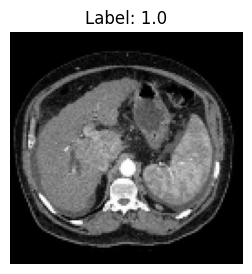

In [ ]:
image, label = dataset[100]["image"], dataset[100]["label"]                   ## Tumor Image
plt.figure(figsize=(3, 5))
plt.imshow(image.reshape(128, 128, 3))
plt.title(f"Label: {label}")
plt.axis(False)

2. Converting the image to tensor format

In [ ]:
image = torch.from_numpy(image).unsqueeze(dim=0).to(device)

3. Passing the image to the conv layers and generating the feature maps

In [ ]:
## first conv_layer has 6 filters, so 6 feature maps will be produced.
## Results will have the results of all the conv layers in a list format
results = [conv_layers[0](image)]                               ## Passing the input image to the first conv layer.
for current_layer in range(1, len(conv_layers)):                ## Starting from index 1 as the first conv layer has already been parsed through.
    results.append(conv_layers[current_layer](results[-1]))     ## Here we pass the feature_maps of the last conv layer to the next conv layer.

In [ ]:
len(results)            ## there will be 2 sets of feature maps, one for each conv layer.

2

In [ ]:
results[0].shape, results[1].shape

(torch.Size([1, 6, 124, 124]), torch.Size([1, 16, 120, 120]))

In [ ]:
for conv_layer_output_index in range(len(results)):
    plt.figure(figsize=(50, 10))
    feature_maps = results[conv_layer_output_index].squeeze()
    print(f"Feature Maps of Conv2D Layer: {conv_layer_output_index + 1}")
    for index, feature_map in enumerate(feature_maps):
        plt.subplot(2, 8, index+1)
        plt.imshow(feature_map.detach().cpu().numpy())
        plt.axis(False)
    plt.show()
    plt.close()

# Model Evaluation with Validation Set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
class BrainMRIDataset(Dataset):
    def __init__(self):

        data_path = "/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
        yes_path = data_path + "/yes/*.[jJ][pP][gG]"        ## To get image.JPG and image.jpg
        no_path = data_path + "/no/*.[jJ][pP][gG]"

        tumor = list()
        healthy = list()


        for f in glob.iglob(yes_path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))           ## Images are not of standard shape, all of them have 3 channels
            # b, g, r = cv2.split(img)                  ## Splitting the image into indiviindividual channels
            # img = cv2.merge([r, g, b])                ## Image channels are in B-G-R format, we want to put them in R-G-B format
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)

        for f in glob.iglob(no_path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))           ## Images are not of standard shape, all of them have 3 channels
            # b, g, r = cv2.split(img)                  ## Splitting the image into indiviindividual channels
            # img = cv2.merge([r, g, b])                ## Image channels are in B-G-R format, we want to put them in R-G-B format
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)

        ## Images
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)
        self.images = np.concatenate((tumor, healthy), axis=0)    ## With axis=0 --> (100, 3, 128, 128) & (200, 3, 128, 128) beacomes (300, 3, 128, 128)
        # self.images = np.array([transformation(image) for image in self.images])

        ## Labels
        tumor_labels = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_labels = np.zeros(healthy.shape[0], dtype=np.float32)
        self.labels = np.concatenate((tumor_labels, healthy_labels))

        self.X_train, self.X_val, self.y_train, self.y_val = None, None, None, None
        self.mode = "train"

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.images, self.labels,
                                                                              test_size=0.2, random_state=42)

    def __len__(self):
        # return len(self.images)           ## len() Works better with list data, numpy arrays and torch tensors have dimensionality
        if self.mode == "train":
            return self.X_train.shape[0]
        elif self.mode == "val":
            return self.X_val.shape[0]

    def __getitem__(self, index):
        if self.mode == "train":
            sample = {"image": self.X_train[index], "label": self.y_train[index]}
        elif self.mode == "val":
            sample = {"image": self.X_val[index], "label": self.y_val[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0

In [ ]:
dataset = BrainMRIDataset()
dataset.normalize()
dataset.train_val_split()

In [ ]:
# dataset.mode = "train"
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# dataset.mode = "val"
val_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

(2, 2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
model = BrainMRIModelCNN().to(device)
model

BrainMRIModelCNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
epoch_train_loss, epoch_val_loss = list(), list()

for epoch in tqdm(range(401)):
    model.train()
    train_losses = list()
    dataset.mode = "train"                  ## This makes sense because the dataloader loads the data each time from dataset class during the iterations
    for train_data in train_dataloader:
        X_train, y_train = train_data["image"].to(device), train_data["label"].to(device)
        y_train_pred_probs = model(X_train).squeeze()
        train_loss = torch.sum(loss_fn(y_train_pred_probs, y_train))
        train_losses.append(train_loss.item())
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    epoch_train_loss.append(np.mean(train_losses))

    model.eval()
    val_losses = list()
    dataset.mode = "val"
    with torch.inference_mode():
        for test_data in val_dataloader:
            X_test, y_test = test_data["image"].to(device), test_data["label"].to(device)
            y_test_pred_probs = model(X_test).squeeze()
            test_loss = torch.sum(loss_fn(y_test_pred_probs, y_test))
            val_losses.append(test_loss.item())
    epoch_val_loss.append(np.mean(val_losses))

    if epoch % 50 == 0:
        print(f"EPOCH: {epoch} | TRAIN LOSS: {np.mean(train_losses): .5f} | TEST LOSS: {np.mean(val_losses): .5f}")

  0%|          | 0/401 [00:00<?, ?it/s]

EPOCH: 0 | TRAIN LOSS:  0.67960 | TEST LOSS:  0.65168
EPOCH: 50 | TRAIN LOSS:  0.54222 | TEST LOSS:  0.52105
EPOCH: 100 | TRAIN LOSS:  0.44495 | TEST LOSS:  0.49185
EPOCH: 150 | TRAIN LOSS:  0.39359 | TEST LOSS:  0.46559
EPOCH: 200 | TRAIN LOSS:  0.37530 | TEST LOSS:  0.46541
EPOCH: 250 | TRAIN LOSS:  0.28923 | TEST LOSS:  0.49087
EPOCH: 300 | TRAIN LOSS:  0.23256 | TEST LOSS:  0.55195
EPOCH: 350 | TRAIN LOSS:  0.17453 | TEST LOSS:  0.65614
EPOCH: 400 | TRAIN LOSS:  0.09864 | TEST LOSS:  0.81824


In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_train_loss, c='b', label="Train Loss")
plt.plot(epoch_val_loss, c='r', label="Test Loss")
plt.xlabel("EPOCHS", fontsize=20)
plt.ylabel("LOSS", fontsize=20)
plt.legend()
plt.grid()

NameError: name 'plt' is not defined

At around 80 epochs, the model has started to overfit.